# Version information

In [53]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: March 05, 2022
Pyleecan version:1.3.7
SciDataTool version:1.4.24


# How to compute magnetic forces using Force Module

This tutorial shows the different steps to **compute magnetic forces** with pyleecan.
 
The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Force.ipynb).

To demonstrate the capabilities and the use of the SciDataTool objects, a simulation is launched with FEMM, with imposed currents, using periodicity and parallelization to reduce execution time.

In [54]:
from numpy import exp, sqrt, pi
from os.path import join
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.Output import Output
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
from pyleecan.Classes.OPdq import OPdq

# Load the machine
Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))

# Simulation initialization
simu = Simu1(name="FEMM_periodicity", machine=Toyota_Prius)


simu.input = InputCurrent(
#    Na_tot=252 * 8,
#    Nt_tot=50 * 8,
    Na_tot=5 * 2 ** 8, Nt_tot=2
)
# Set Id/Iq according to I0/Phi0
simu.input.OP = OPdq(N0=1000)
simu.input.OP.set_I0_Phi0(I0=250 / sqrt(2), Phi0=140*pi/180)

# Definition of the magnetic simulation: with periodicity
simu.mag = MagFEMM(is_periodicity_a=True, is_periodicity_t=True, nb_worker=4)
simu.force = ForceMT(is_periodicity_a=True, is_periodicity_t=True)

# Run simulations
out = simu.run()

[20:53:16] Starting running simulation FEMM_periodicity (machine=Toyota_Prius)
[20:53:16] Starting Magnetic module
[20:53:16] In Magnetic model, Nt_tot=2 is not divisible by the machine time periodicity (4). Time periodicity removed
[20:53:17] Solving time step 1 / 2 in FEMM
[20:53:18] Solving time step 2 / 2 in FEMM
[20:53:19] Starting Force module
[20:53:19] In Force model, Nt_tot=2 is not divisible by the machine time periodicity (4). Time periodicity removed
[20:53:19] End of simulation FEMM_periodicity


mag parent and Slice

In [121]:

a=simu.parent._mag
aa=a.parent.mag
ass=a.parent.mag.Slice
ass.is_skew
ass.Nslices
ass.L



0.08382

In [159]:
#slice_model = self.get_slice_model()
#output.mag.Slice = slice_model
out.mag.axes_dict
a=out

Skew

In [ ]:
.comp_axes()

# Get z axis
Slice_axis = axes_dict["z"]
unique_indices = Slice_axis.unique_indices

In [120]:
simu.machine.rotor.skew


## Force Module
The Force abstract class will make it possible to define different ways of calculating forces. 

The ForceMT class inherits from Force class. ForceMT is dedicated to the computation of air-gap surface force based on the Maxwell stress tensor \[[source](https://eomys.com/IMG/pdf/comparison-main-magnetic.pdf)\]. 

Here, we get the results from a magnetic simulation without any force calculation. The Force module is initialized and run alone. 

In [5]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.ForceMT import ForceMT

# Create the Simulation
mySimu = Simu1(name="Tuto_Force")  
mySimu.parent = out
mySimu.force = ForceMT()

# Run only the force module
out_mySimu=mySimu.force.run()
mySimu.force    

[14:53:18] Starting Force module


AttributeError: 'ForceMT' object has no attribute 'AGSF'

In [56]:
out_mySimu.AGSF.plot_2D_Data("angle{°}", **dict_2D)
out_mySimu.AGSF.plot_2D_Data("wavenumber=[0,78]", **dict_2D)

AttributeError: 'NoneType' object has no attribute 'AGSF'

Once the simulation is finished, the results are stored in the force part of the output (i.e. _myResults.force_ ) and we can call different plots. This object contains:   
- *Time*: Time axe
- *Angle*: Angular position axe   
- *AGSF*: Airgap surface force (Radial and Tangential component)
    
**Output** object embbed different plot to visualize results easily. You can find a dedicated tutorial [here](https://www.pyleecan.org/tuto_Plots.html).

Here are some example of useful plots.

<IPython.core.display.Javascript object>


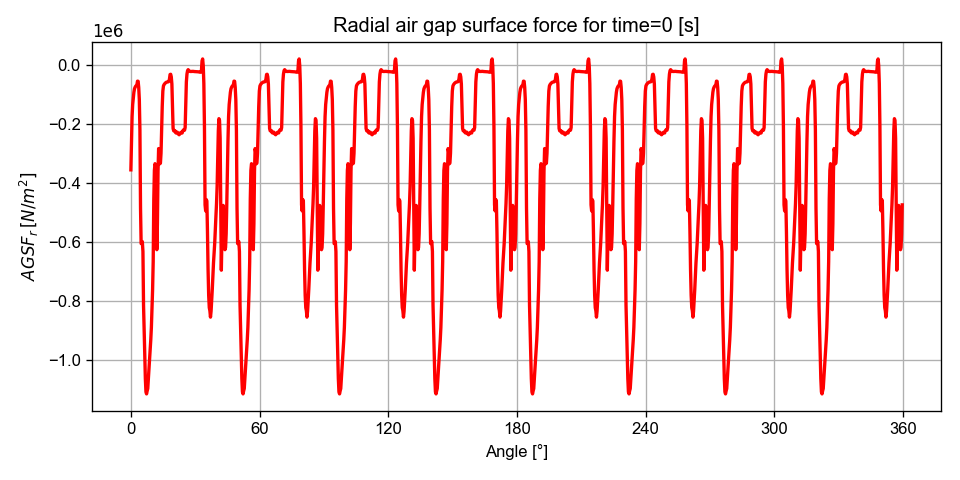

<IPython.core.display.Javascript object>


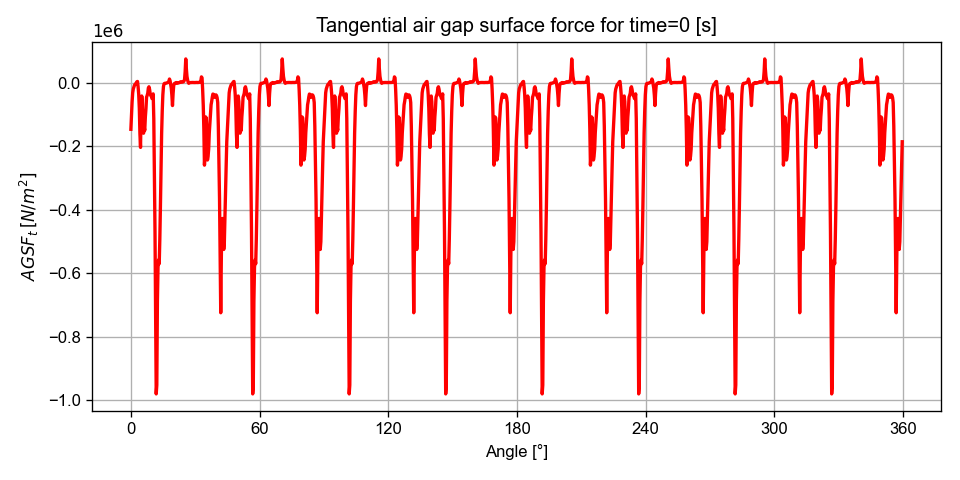

<IPython.core.display.Javascript object>


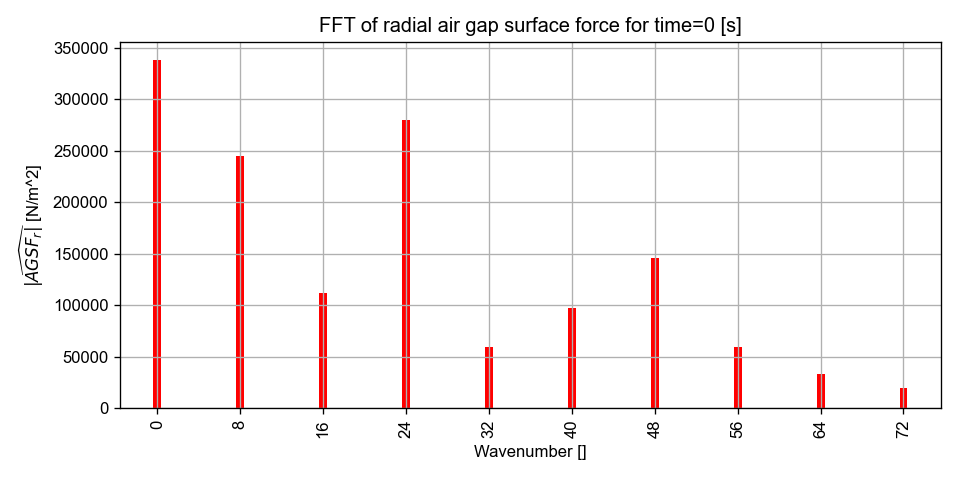

<IPython.core.display.Javascript object>


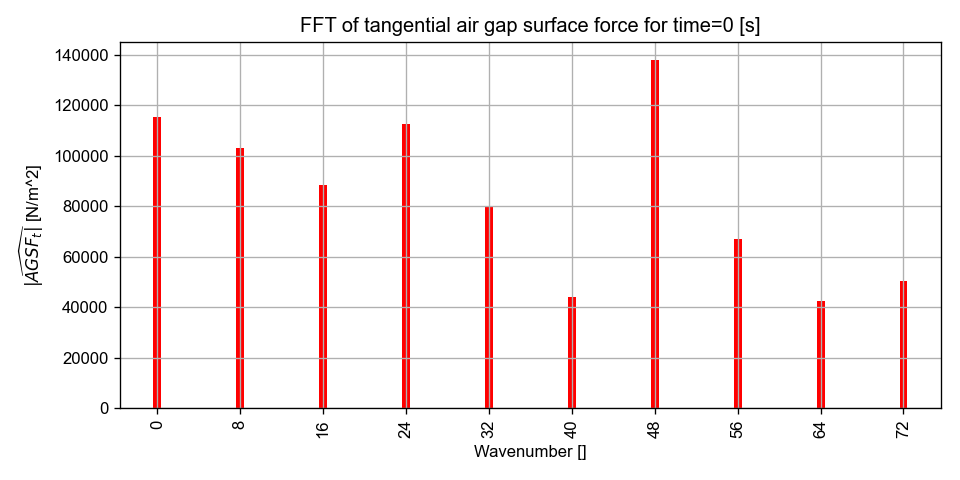

In [8]:
%matplotlib notebook
from pyleecan.Functions.Plot import dict_2D, dict_3D
out.force.AGSF.plot_2D_Data("angle{°}", **dict_2D)
out.force.AGSF.plot_2D_Data("wavenumber=[0,78]", **dict_2D)

<IPython.core.display.Javascript object>


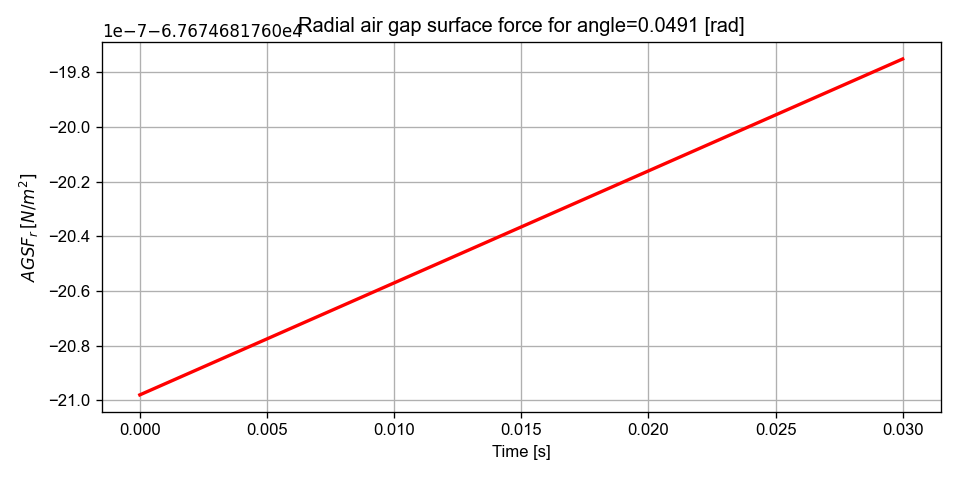

<IPython.core.display.Javascript object>


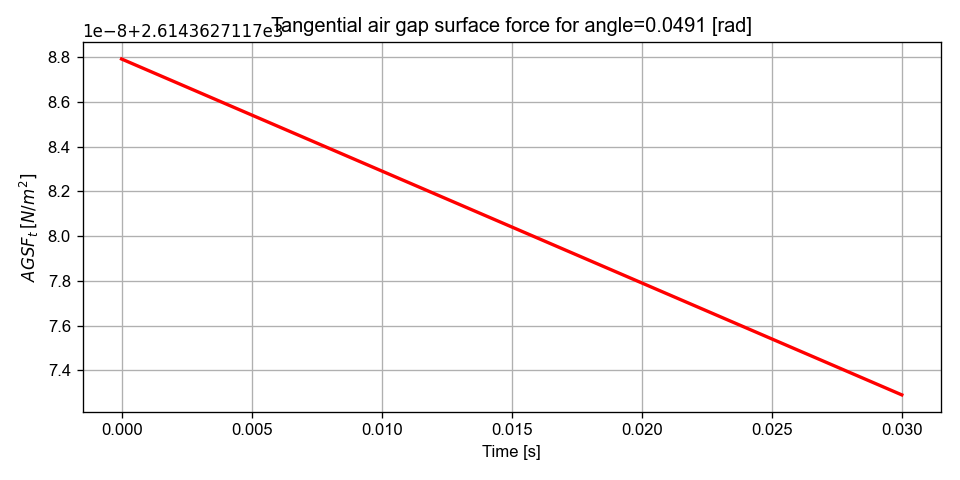

<IPython.core.display.Javascript object>


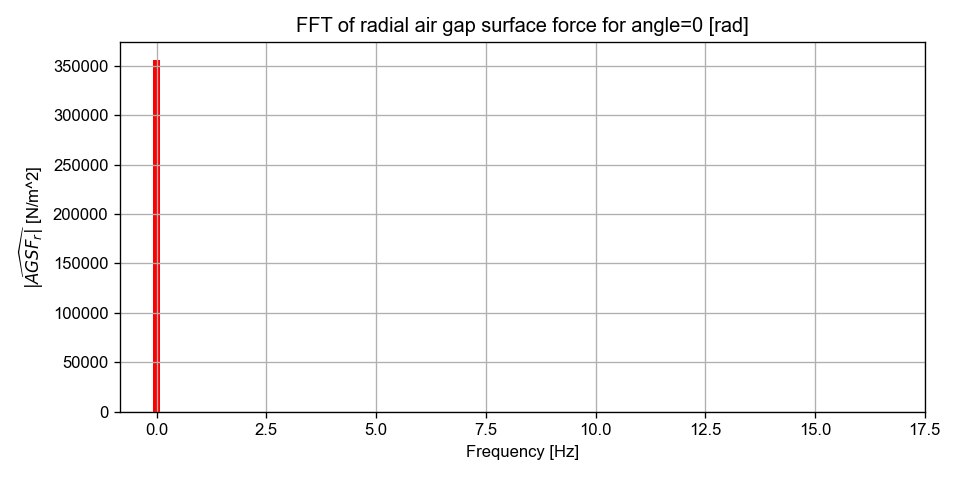

<IPython.core.display.Javascript object>


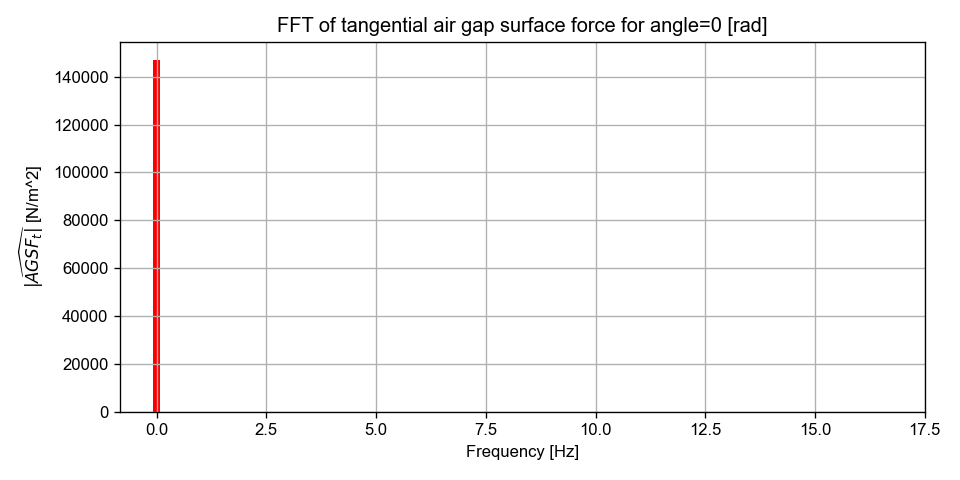

In [4]:
from numpy import pi

#------------------------------------------------------
# Plot the air-gap force as a function of time with the time fft
out.force.AGSF.plot_2D_Data("time","angle[10]", is_auto_ticks=False, **dict_2D)
out.force.AGSF.plot_2D_Data("freqs=[0,4000]", is_auto_ticks=False, **dict_2D)
#------------------------------------------------------

The following plot displays the radial air-gap surface force over time and angle. 

<IPython.core.display.Javascript object>


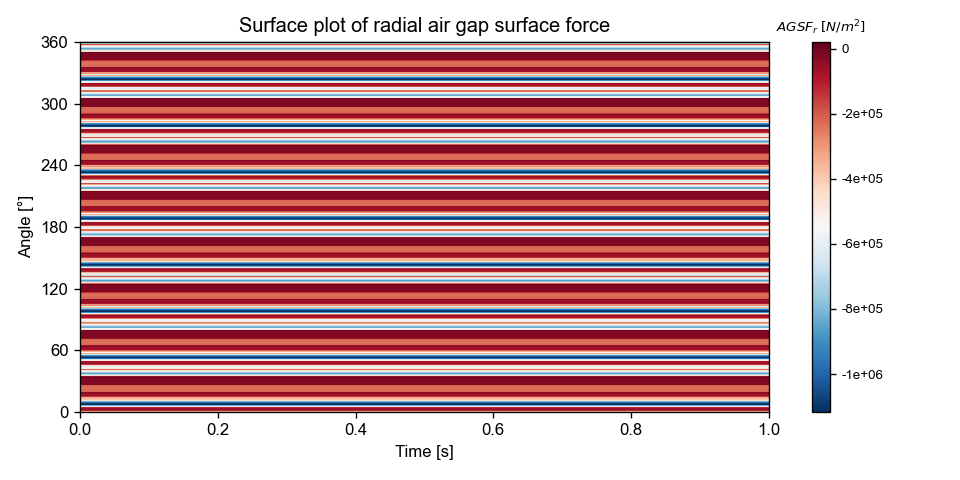

<IPython.core.display.Javascript object>


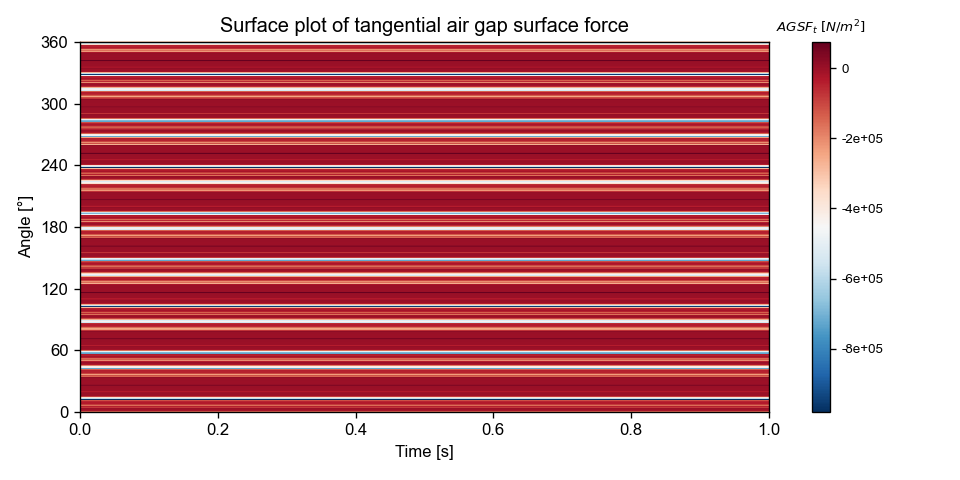

<IPython.core.display.Javascript object>


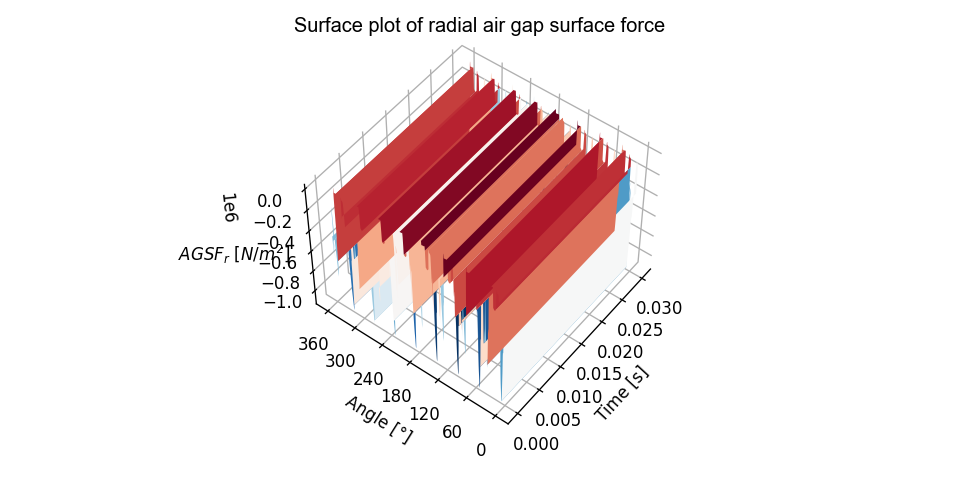

<IPython.core.display.Javascript object>


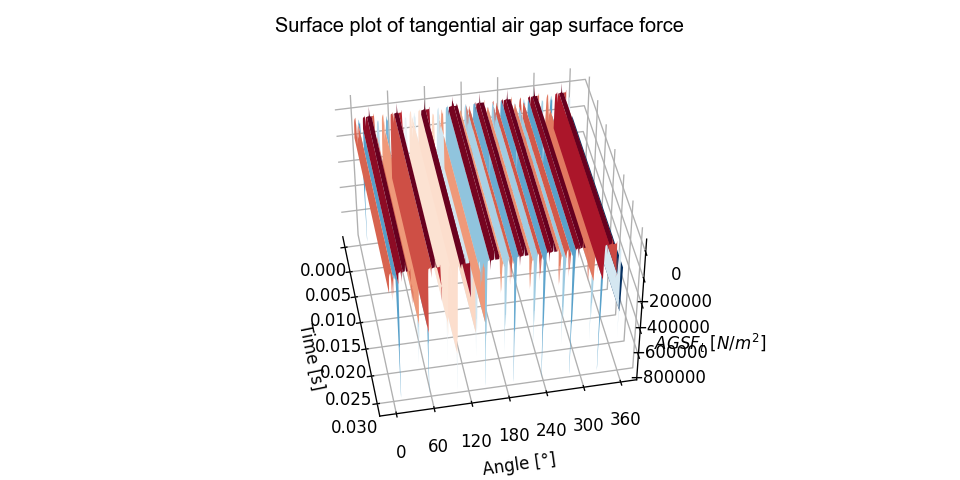

In [6]:
#------------------------------------------------------
# Plot the tangential force as a function of time and space
out.force.AGSF.plot_3D_Data("time", "angle{°}", is_2D_view=True, **dict_3D)
out.force.AGSF.plot_3D_Data("time", "angle{°}", is_2D_view=False, **dict_3D)
#------------------------------------------------------